In [2]:
from datetime import datetime
from datetime import timedelta
import numpy as np
import random


# Stone Soup imports:
from stonesoup.types.state import State, GaussianState
from stonesoup.types.array import StateVector, CovarianceMatrix
from stonesoup.models.transition.linear import (
    CombinedLinearGaussianTransitionModel, ConstantVelocity)
from stonesoup.models.measurement.nonlinear import \
    CartesianToElevationBearingRange
from stonesoup.deleter.time import UpdateTimeStepsDeleter
from stonesoup.tracker.simple import MultiTargetMixtureTracker
from matplotlib import pyplot as plt

start_time = datetime.now()
np.random.seed(783)
random.seed(783)

platform_state_vector = StateVector([[0], [0], [0]])
position_mapping = (0, 1, 2)

platform_state = State(platform_state_vector, start_time)

from stonesoup.platform.base import FixedPlatform
platform = FixedPlatform(
    states=platform_state,
    position_mapping=position_mapping
)

from stonesoup.sensor.radar.radar import RadarElevationBearingRange
from stonesoup.models.clutter import ClutterModel

noise_covar = CovarianceMatrix(np.array(np.diag([np.deg2rad(0.15)**2,
                                                 np.deg2rad(0.15)**2,
                                                 25**2])))

radar_mapping = (0, 2, 4)

params = ((-10000, 10000),  # clutter min x and max x
          (-10000, 10000),  # clutter min y and max y
          (8000, 10000))  # clutter min z and max z
clutter_model = ClutterModel(
     clutter_rate=0.5,
     distribution=np.random.default_rng().uniform,
     dist_params=params
)

radar = RadarElevationBearingRange(
    ndim_state=6,
    position_mapping=radar_mapping,
    noise_covar=noise_covar,
    clutter_model=clutter_model
)

platform.add_sensor(radar)

transition_model = CombinedLinearGaussianTransitionModel(
    [ConstantVelocity(0.5), ConstantVelocity(0.5), ConstantVelocity(0.1)])

initial_target_state = GaussianState(
    state_vector=StateVector([[0], [0], [0], [0], [9000], [0]]),
    covar=CovarianceMatrix(np.diag([2000, 50, 2000, 50, 100, 1]))
)

from stonesoup.simulator.simple import MultiTargetGroundTruthSimulator
groundtruth_sim = MultiTargetGroundTruthSimulator(
    transition_model=transition_model,  # target transition model
    initial_state=initial_target_state,  # add our initial state for targets
    timestep=timedelta(seconds=1),  # time between measurements
    number_steps=120,  # 2 minutes
    birth_rate=0.05,  # 5% chance of a new target being born every second
    death_probability=0.05  # 5% chance of a target being killed
)

from stonesoup.simulator.platform import PlatformDetectionSimulator

sim = PlatformDetectionSimulator(
    groundtruth=groundtruth_sim,
    platforms=[platform]
)

from stonesoup.predictor.kalman import KalmanPredictor
predictor = KalmanPredictor(transition_model)

meas_covar = np.diag([np.deg2rad(0.5), np.deg2rad(0.15), 25])
meas_covar_trk = CovarianceMatrix(1.0*np.power(meas_covar, 2))
meas_model = CartesianToElevationBearingRange(
    ndim_state=6,
    mapping=(0, 2, 4),
    noise_covar=meas_covar_trk
)

from stonesoup.updater.kalman import ExtendedKalmanUpdater
updater = ExtendedKalmanUpdater(measurement_model=meas_model)

from stonesoup.hypothesiser.probability import PDAHypothesiser
Pd = 0.95  # 95%
hypothesiser = PDAHypothesiser(predictor=predictor,
                               updater=updater,
                               clutter_spatial_density=0.5,
                               prob_detect=Pd)

from stonesoup.dataassociator.probability import JPDA
data_associator = JPDA(hypothesiser=hypothesiser)

deleter = UpdateTimeStepsDeleter(time_steps_since_update=3)

2024-02-08 18:48:20.460259
2024-02-08 18:48:21.460259
2024-02-08 18:48:22.460259
2024-02-08 18:48:23.460259
2024-02-08 18:48:24.460259
2024-02-08 18:48:25.460259
2024-02-08 18:48:26.460259
2024-02-08 18:48:27.460259
2024-02-08 18:48:28.460259
2024-02-08 18:48:29.460259
2024-02-08 18:48:30.460259
2024-02-08 18:48:31.460259
2024-02-08 18:48:32.460259
2024-02-08 18:48:33.460259
2024-02-08 18:48:34.460259
2024-02-08 18:48:35.460259
2024-02-08 18:48:36.460259
2024-02-08 18:48:37.460259
2024-02-08 18:48:38.460259
2024-02-08 18:48:39.460259
2024-02-08 18:48:40.460259
2024-02-08 18:48:41.460259
2024-02-08 18:48:42.460259
2024-02-08 18:48:43.460259
2024-02-08 18:48:44.460259
2024-02-08 18:48:45.460259
2024-02-08 18:48:46.460259
2024-02-08 18:48:47.460259
2024-02-08 18:48:48.460259
2024-02-08 18:48:49.460259
2024-02-08 18:48:50.460259
2024-02-08 18:48:51.460259
2024-02-08 18:48:52.460259
2024-02-08 18:48:53.460259
2024-02-08 18:48:54.460259
2024-02-08 18:48:55.460259
2024-02-08 18:48:56.460259
2

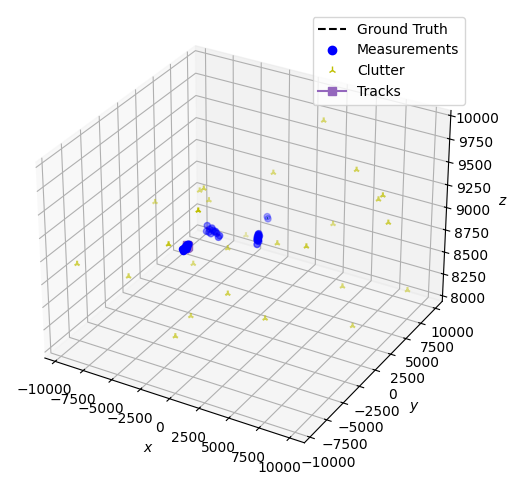

In [3]:
from stonesoup.initiator.simple import MultiMeasurementInitiator
from stonesoup.dataassociator.neighbour import NearestNeighbour

min_detections = 3  # number of detections required to begin a track
initiator_prior_state = GaussianState(
    state_vector=np.array([[0], [0], [0], [0], [0], [0]]),
    covar=np.diag([0, 10, 0, 10, 0, 10])**2
)

initiator_meas_model = CartesianToElevationBearingRange(
    ndim_state=6,
    mapping=np.array([0, 2, 4]),
    noise_covar=noise_covar
)

initiator = MultiMeasurementInitiator(
    prior_state=initiator_prior_state,
    measurement_model=meas_model,
    deleter=deleter,
    data_associator=NearestNeighbour(hypothesiser),
    updater=updater,
    min_points=min_detections,
    updates_only=True
)

JPDA_tracker = MultiTargetMixtureTracker(
    initiator=initiator,
    deleter=deleter,
    detector=sim,
    data_associator=data_associator,
    updater=updater
)

# Create lists to hold the information we want to plot later
tracks_plot = set()
tracks_id = set()
groundtruth_plot = set()
detections_plot = set()

# Run the simulation and tracker
for time, ctracks in JPDA_tracker:
    print(time)  # allows us to see the progress of the tracking simulation

    for track in ctracks:
        tracks_plot.add(track)
    for truth in groundtruth_sim.current[1]:
        groundtruth_plot.add(truth)
    for detection in sim.detections:
        detections_plot.add(detection)
        
from stonesoup.plotter import Plotter, Dimension
plotter = Plotter(Dimension.THREE)
plotter.plot_ground_truths(groundtruth_plot, [0, 2, 4])
plotter.plot_measurements(detections_plot, [0, 2, 4])
plotter.plot_tracks(tracks_plot, [0, 2, 4], uncertainty=False, err_freq=5)

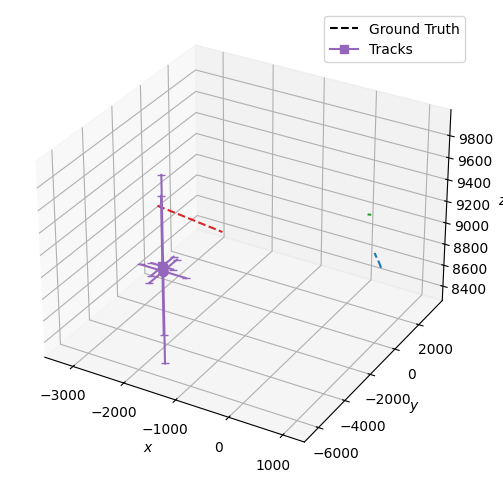

In [4]:
plotter2 = Plotter(Dimension.THREE)
plotter2.plot_ground_truths(groundtruth_plot, [0, 2, 4])
plotter2.plot_tracks(tracks_plot, [0, 2, 4], uncertainty=True, err_freq=5)

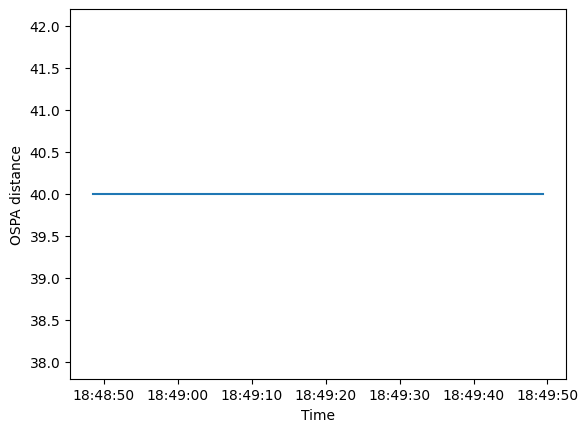

In [6]:
# OSPA metric
from stonesoup.metricgenerator.ospametric import OSPAMetric
ospa_generator = OSPAMetric(c=40, p=1)

# SIAP metrics
from stonesoup.metricgenerator.tracktotruthmetrics import SIAPMetrics
from stonesoup.measures import Euclidean
SIAPpos_measure = Euclidean(mapping=np.array([0, 2]))
SIAPvel_measure = Euclidean(mapping=np.array([1, 3]))
siap_generator = SIAPMetrics(
    position_measure=SIAPpos_measure,
    velocity_measure=SIAPvel_measure
)

# Uncertainty metric
from stonesoup.metricgenerator.uncertaintymetric import \
    SumofCovarianceNormsMetric
uncertainty_generator = SumofCovarianceNormsMetric()

from stonesoup.dataassociator.tracktotrack import TrackToTruth
associator = TrackToTruth(association_threshold=30)

from stonesoup.metricgenerator.manager import SimpleManager
metric_manager = SimpleManager(
    [ospa_generator, siap_generator, uncertainty_generator],
    associator=associator
)

metric_manager.add_data(groundtruth_plot, tracks_plot)
metrics = metric_manager.generate_metrics()

ospa_metric = metrics["OSPA distances"]

fig, ax = plt.subplots()
ax.plot([i.timestamp for i in ospa_metric.value],
        [i.value for i in ospa_metric.value])
ax.set_ylabel("OSPA distance")
_ = ax.set_xlabel("Time")

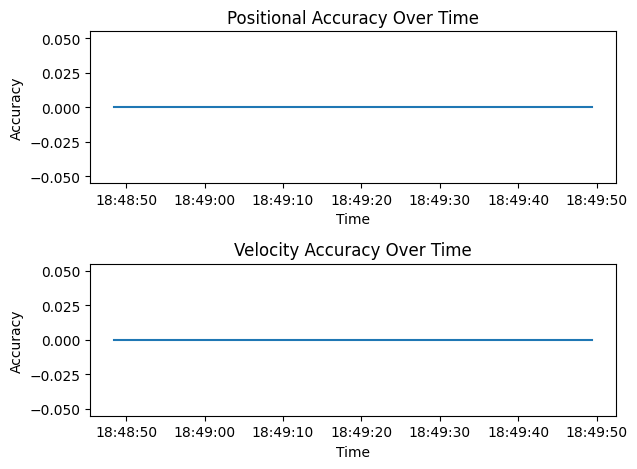

In [7]:
position_accuracy = metrics['SIAP Position Accuracy at times']
velocity_accuracy = metrics['SIAP Velocity Accuracy at times']
times = metric_manager.list_timestamps()

# Make a figure with 2 subplots.
fig, axes = plt.subplots(2)

# The first subplot will show the position accuracy
axes[0].set(title='Positional Accuracy Over Time', xlabel='Time',
            ylabel='Accuracy')
axes[0].plot(times, [metric.value for metric in position_accuracy.value])

# The second subplot will show the velocity accuracy
axes[1].set(title='Velocity Accuracy Over Time', xlabel='Time',
            ylabel='Accuracy')
axes[1].plot(times, [metric.value for metric in velocity_accuracy.value])
plt.tight_layout()

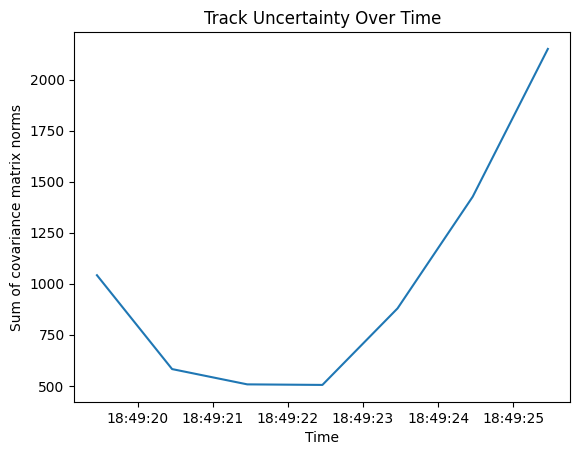

In [8]:
uncertainty_metric = metrics["Sum of Covariance Norms Metric"]

fig, ax = plt.subplots()
ax.plot([i.timestamp for i in uncertainty_metric.value],
        [i.value for i in uncertainty_metric.value])
_ = ax.set(title="Track Uncertainty Over Time", xlabel="Time",
           ylabel="Sum of covariance matrix norms")